# Data

- $C=\{1,2,3,4,5,6,7,8\}$ $\leftarrow$ set of cities to visit.

- $n = 8$ $\leftarrow$ number of cities.

In [1]:
cities = [c + 1 for c in range(8)]
cities

[1, 2, 3, 4, 5, 6, 7, 8]

- $D=(d_{ij})$, $i,j \in C$ $\leftarrow$ matrix of distances between cities.

In [2]:
distances = [
    [0, 89, 87, 38, 33, 71, 59, 54],
    [89, 0, 32, 59, 65, 39, 45, 61],
    [87, 32, 0, 50, 75, 17, 64, 79],
    [38, 59, 50, 0, 40, 33, 50, 56],
    [33, 65, 75, 40, 0, 62, 26, 21],
    [71, 39, 17, 33, 62, 0, 57, 70],
    [59, 45, 64, 50, 26, 57, 0, 16],
    [54, 61, 79, 56, 21, 70, 16, 0]
]

# Decision

- $T=\{t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9=t_1\}$, $t_i \in C$ $\leftarrow$ ordered set of visited cities.

- $T = \{\}$ $\leftarrow$ initialize tour as an empty set.

In [3]:
tour = []

# Objective

The objective is to get a tour $T$ that visits all cities in $C$, ending with the first city, such that the total distance of the tour is as minimal as possible.

$$
\begin{aligned}
& \underset{t \in T}{\text{min}}
& & \sum_{i=1}^{n} d_{t_i t_{i+1}}
\end{aligned}
$$

# Procedure

## Initial step

To start the tour, the two nearest cities will be chosen first; that is, we will find the smallest edge in the matrix of distances, excluding the positions of the same cities:

In [4]:
minimums = (min(enumerate(row), key=lambda l: l[1] if l[1] > 0 else float('inf')) for _, row in enumerate(distances))
smallest = min(enumerate(minimums), key=lambda m: m[1][1])
smallest[1][1]

16

The smallest edge is $16$, but what we need are the coordinates (the cities) to which that edge belongs:

In [5]:
c1 = smallest[0] + 1
c2 = smallest[1][0] + 1
c1, c2

(7, 8)

Now we can append cities $7$ and $8$ to our tour $T$:

$T=T\oplus\{7, 8\}$

In [6]:
tour.extend([7, 8])
tour

[7, 8]

In the TSP, the tour ends with the first visited city, so our tour $T$ should look like $\{7, 8, \ldots, 7\}$:

In [7]:
tour.append(7)
tour

[7, 8, 7]

The previous selected cities need to be removed from the set of cities $C$. In order to avoid modifying $C$, we will use a new set to store the unvisited cities:

$\bar{C}=C\setminus\{7, 8\}$

In [8]:
cities_bar = list(cities)
cities_bar.remove(7)
cities_bar.remove(8)
cities_bar

[1, 2, 3, 4, 5, 6]

## Plotting

To illustrate the path of each subtour, we will declare a function to make the corresponding plot for every iteration. Before anything else, let's declare the coordinates of the cities:

In [9]:
coords = (    # cities
    (86, 37), # 1
    (17, 94), # 2
    (3, 65),  # 3
    (48, 43), # 4
    (78, 70), # 5
    (17, 55), # 6
    (62, 91), # 7
    (78, 91)  # 8
)

First, we will make a plot only for the cities:

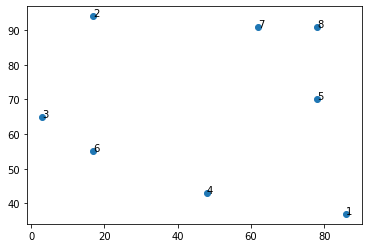

In [10]:
import matplotlib.pyplot as plt
x_coords = [c[0] for c in coords]
y_coords = [c[1] for c in coords]
%matplotlib inline
plt.scatter(x_coords, y_coords)
for city, tag in enumerate(cities):
    plt.annotate(tag, (x_coords[city], y_coords[city]))
plt.show()

Now we can declare the function for the loop:

In [11]:
def plot_tour():
    '''Plots the path of the subtour.'''
    plt.scatter(x_coords, y_coords)
    for city, tag in enumerate(cities):
        plt.annotate(tag, (x_coords[city], y_coords[city]))
    global tour
    sorted_coords = [coords[k] for k in [t - 1 for t in tour]]
    x_values = [c[0] for c in sorted_coords]
    y_values = [c[1] for c in sorted_coords]
    plt.plot(x_values, y_values)
    plt.show()

And plot the path of the current subtour $T$:

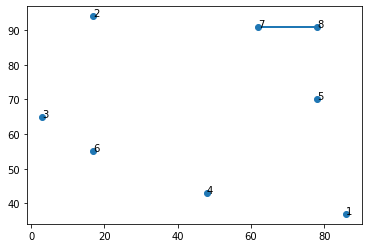

In [12]:
plot_tour()

## Nearest Insertion Heuristic

In order to solve the TSP, we will to apply the **nearest insertion heuristic**.

This technique consists of selecting the closest city to the current tour, which is actually a subtour, because we haven't visited all cities yet. Then we choose an edge of the subtour in which we will insert the selected city such that the cost of breaking it is minimal.

### Distance function

The closest city is the one whose sum of distances to every visited city in the subtour is the smallest.

$$
\newcommand{\dist}{\mathop{\mathrm{dist}}}
\dist(c \in \bar{C}) = \sum_{t \in T} d_{ct}
$$

In [13]:
def dist(candidate_city):
    '''Calculates the distance between candidate_city and the current subtour.'''
    return sum(distances[candidate_city - 1][t - 1] for t in tour)

### Cost function

Having the next city to visit already selected, we proceed to choose an edge of the subtour in which the selected city will be inserted. This is determined by calculating the cost of removing the existing edge and creating two new ones, in order to connect the selected city $c_s$, and choose the smallest cost.

$$
\newcommand{\cost}{\mathop{\mathrm{cost}}}
\cost(c_s, E) = d_{c_s e_0} + d_{c_s e_1} - d_{e_0 e_1}
$$
$$
e \in E
$$
$$
\forall E \subset T, |E| = 2
$$

$E$ represents an edge of the tour $T$, which has only the two cities that form that edge, being $e_0$ and $e_1$. This two cities also belong to $T$.

In [14]:
def cost(selected_city, edge):
    '''Calculates the cost of inserting the selected city in the edge.'''
    e0, e1 = edge
    distance_cs_e0 = distances[selected_city - 1][e0 - 1]
    distance_cs_e1 = distances[selected_city - 1][e1 - 1]
    distance_e0_e1 = distances[e0 - 1][e1 - 1]
    return distance_cs_e0 + distance_cs_e1 - distance_e0_e1

## Loop

Now we will enter in a loop to check which remaining cities, $\forall c \in \overline{C}$, to visit next and add them in an order to our tour $T$.

The body of the whole loop looks as follows:

**
while $\bar{C} \ne \emptyset$ do  
$\hbox{}\qquad c_s \leftarrow \newcommand{\argmin}{\mathop{\mathrm{argmin}}\limits} \argmin_{c \in \bar{C}} \newcommand{\dist}{\mathop{\mathrm{dist}}} \{\dist (c)\}$  
$\hbox{}\qquad k \leftarrow \newcommand{\argmin}{\mathop{\mathrm{argmin}}\limits} \argmin_{E \subset T} \newcommand{\cost}{\mathop{\mathrm{cost}}} \{\cost (c_s, E)\}$  
$\hbox{}\qquad T (t_1, \ldots, t_n) \leftarrow T (t_1, \ldots, t_k, c_s, t_{k+1}, \ldots, t_n)$  
$\hbox{}\qquad \bar{C} \leftarrow \bar{C} \setminus \{c_s\}$  
end while
**

To calculate $c_s \leftarrow \newcommand{\argmin}{\mathop{\mathrm{argmin}}\limits} \argmin_{c \in \bar{C}} \newcommand{\dist}{\mathop{\mathrm{dist}}} \{\dist (c)\}$, we will use the following function which will help us getting the actual nearest city:

In [15]:
def nearest():
    '''Returns a list of distances between each city and the subtour.'''
    return [(city, dist(city)) for _, city in enumerate(cities_bar)]

In the same way, to calculate $k \leftarrow \newcommand{\argmin}{\mathop{\mathrm{argmin}}\limits} \argmin_{E \subset T} \newcommand{\cost}{\mathop{\mathrm{cost}}} \{\cost (c_s, E)\}$, we will use the following function:

In [16]:
def argmin_cost(city):
    '''Returns a list of costs of each city in the subtour.'''
    indexed_costs = list()
    for i in range(len(tour) - 1):
        edge = (tour[i], tour[i + 1])
        indexed_costs.append((i + 1, cost(city, edge)))
    return indexed_costs

And finally, to update the tour we will use a function to insert the selected city $c_s$, obtained by checking the results of `nearest()`, next to the city $t_k$ in the subtour that has the smallest cost, obtained by checking the results of `argmin_cost()`, as follows:

In [17]:
def update_tour(city, k):
    '''Inserts the selected city in the k index of the tour.'''
    global tour
    tour = tour[:k] + [city] + tour[k:]
    return tour

### First iteration

As we already know that we need to visit six more cities to complete the tour, we can start by checking which unvisited city is the closest from our subtour:

In [18]:
nearest()

[(1, 172), (2, 151), (3, 207), (4, 156), (5, 73), (6, 184)]

We can see that the city $5$ is the *nearest* to the subtour, $\therefore$ $c_s = 5$.

Now we want to know the index of the city in the subtour that will be previous to $5$. In this case, because we are in the first iteration, there's only one edge available, so we can insert $5$ between $7$ and $8$ or append it before the end; in both cases, the total length of the subtour would be the same because the cost is the same. Let's append it right after $8$:

In [19]:
update_tour(5, 2)

[7, 8, 5, 7]

Let's see how the path looks:

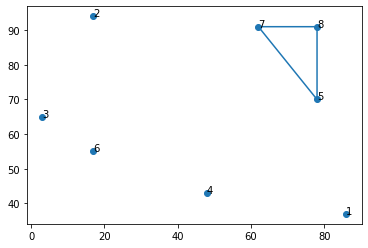

In [20]:
plot_tour()

$\bar{C}$ needs to be updated as the subtour $T$ grows:

$\bar{C} \leftarrow \bar{C} \setminus \{5\}$

In [21]:
cities_bar.remove(5)
cities_bar

[1, 2, 3, 4, 6]

### Second iteration

Let's choose the nearest city to our subtour $T$:

In [22]:
nearest()

[(1, 205), (2, 216), (3, 282), (4, 196), (6, 246)]

The city $4$ is the closest one, with a total distance of $196$. Now let's find the best edge to break from $T$:

In [23]:
argmin_cost(4)

[(1, 90), (2, 75), (3, 64)]

The edge between cities $t_3$ and $t_4$ is the cheapest one to break. These cities are $5$ and $7$, which means that the selected edge is the last one of the subtour:

In [24]:
update_tour(4, 3)

[7, 8, 5, 4, 7]

And how is the path going?

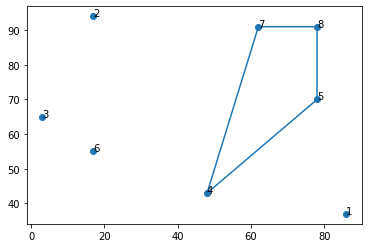

In [25]:
plot_tour()

Now we must update $\bar{C}$ by removing the city $4$:

In [26]:
cities_bar.remove(4)
cities_bar

[1, 2, 3, 6]

### Third iteration

We want to select the closest unvisited city to our subtour $T$:

In [27]:
nearest()

[(1, 243), (2, 275), (3, 332), (6, 279)]

City $1$ is the nearest to $T$. Now to find where to insert it:

In [28]:
argmin_cost(1)

[(1, 97), (2, 66), (3, 31), (4, 47)]

In order to minimize the cost of inserting the selected city, we will choose the $t_3$ to be the previous city to the selected one:

In [29]:
update_tour(1, 3)

[7, 8, 5, 1, 4, 7]

The path of the subtour looks as follows:

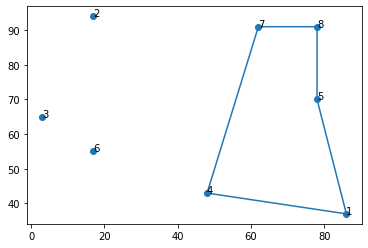

In [30]:
plot_tour()

To finish the iteration, we will remove city $1$ from $\bar{C}$:

In [31]:
cities_bar.remove(1)
cities_bar

[2, 3, 6]

### Fourth iteration

Let's calculate the distance from each unvisited city to our subtour $T$:

In [32]:
nearest()

[(2, 364), (3, 419), (6, 350)]

We will visit city $6$ next because it's the nearest to $T$. However, we need to know after what city in the subtour we will visit $c_s = 6$:

In [33]:
argmin_cost(6)

[(1, 111), (2, 111), (3, 100), (4, 66), (5, 40)]

Let's insert city $6$ right after $t_5$, which is city $4$:

In [34]:
update_tour(6, 5)

[7, 8, 5, 1, 4, 6, 7]

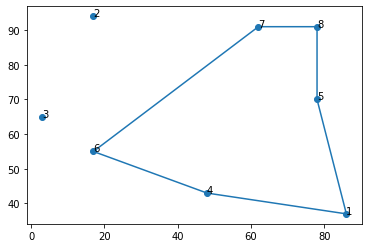

In [35]:
plot_tour()

And remove it from $\bar{C}$:

In [36]:
cities_bar.remove(6)
cities_bar

[2, 3]

### Fifth iteration

This is the last iteration that requires to check which city to visit next, because there are only two left.

In [37]:
nearest()

[(2, 403), (3, 436)]

City $2$ is the next to be visited, so let's find the cheapest edge of the subtour $T$ to break:

In [38]:
argmin_cost(2)

[(1, 90), (2, 105), (3, 121), (4, 110), (5, 65), (6, 27)]

Again, we are going to break the last edge of the current subtour:

In [39]:
update_tour(2, 6)

[7, 8, 5, 1, 4, 6, 2, 7]

Let's take a look at how the path is going:

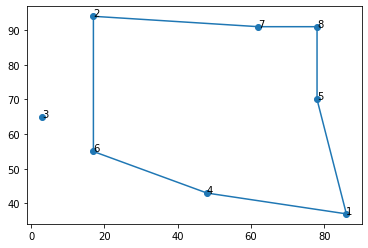

In [40]:
plot_tour()

Now remove city $2$ from $\bar{C}$:

In [41]:
cities_bar.remove(2)
cities_bar

[3]

### Sixth iteration

We already know that city $3$ is the last one to visit, so we just need to get the index of a visited city in our subtour $T$ whose breaking cost is the smallest:

In [42]:
argmin_cost(3)

[(1, 127), (2, 133), (3, 129), (4, 99), (5, 34), (6, 10), (7, 51)]

Finally, to complete the tour $T$, we will break the edge that starts at $t_6$ and insert city $3$ there:

In [43]:
update_tour(3, 6)

[7, 8, 5, 1, 4, 6, 3, 2, 7]

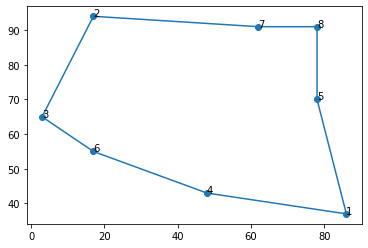

In [44]:
plot_tour()

As we can see, the final tour got a circular shape.

By removing the last city left from $\bar{C}$, we will get an empty set:

In [45]:
cities_bar.remove(3)
cities_bar

[]

This means that our loop has ended, and thus we have calculated a tour $T$.

# Conclusion

We now have our decision variable, the tour $T$.

$T \leftarrow \{7, 8, 5, 1, 4, 6, 3, 2, 7\}$

As we stated at the beginning, the objective function of the TSP is to minimize the total distance of the tour. Let's calculate this distance:

In [46]:
sum(distances[tour[i] - 1][tour[i + 1] - 1] for i in range(len(tour) - 1))

235

In conclusion, by using the nearest insertion heuristic technique, we can visit the cities in the order given by $T$, and when we finish we will have traveled a total distance of $235$.